In [1]:
#mount google drive
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/DLP/DLP_autoXRD/

Mounted at /content/drive
/content/drive/MyDrive/DLP/DLP_autoXRD


# Dependencies

In [2]:
# Loads series of functions for preprocessing and data augmentation
from autoXRD import *
# Loads CAMs visualizations for a-CNN
from autoXRD_vis import *

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.metrics import precision_score

# Neural networks uses Keran with TF background
import keras as K
from keras.models import Model
from keras.models import Sequential
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import EarlyStopping
from keras.layers import GlobalAveragePooling1D
from keras.models import load_model

import tensorflow as tf
from tensorflow import keras


# loading data

THeoretical data:

In [3]:
theor = pd.read_csv('Datasets/theor.csv', index_col=0)
theor = theor.iloc[1:,]
theor_arr=theor.values

# Normalize data for training
ntheor = normdata(theor_arr)

# Load labels for simulated data
label_theo = pd.read_csv('Datasets/label_theo.csv', header=None, index_col=0)
label_theo = label_theo[1].tolist()

In [85]:
ntheor.shape

(2125, 164)

In [83]:
np.shape(label_theo)

(328,)

Experimental data:

In [4]:
# Load experimental data as dataframe
exp_arr_new = pd.read_csv('Datasets/exp.csv', index_col=0)
exp_arr_new = exp_arr_new.values

# Load experimental class labels
label_exp= pd.read_csv('Datasets/label_exp.csv', index_col=0).values
label_exp = label_exp.reshape([len(label_exp),])

# Load class enconding
space_group_enc = pd.read_csv('Datasets/encoding.csv', index_col=0)
space_group_enc = list(space_group_enc['0'])

# Normalize experimental data
nexp = normdata(exp_arr_new)

# Define spectral range for data augmentation
exp_min = 0
exp_max = 1200
theor_min = 125

#window size for experimental data extraction
window = 20
theor_max = theor_min+exp_max-exp_min

# Preprocess experimental data
post_exp = normdatasingle(exp_data_processing (nexp, exp_min, exp_max, window))

In [86]:
theor_max

1325

In [ ]:
ntheor.shape

(2125, 164)

# Data augmentation

In [65]:
################################################################
# Perform data augmentation
################################################################

# Specify how many data points we augmented
th_num = 2000

# Augment data, this may take a bit
augd,pard,crop_augd = augdata(ntheor, th_num, label_theo, theor_min, theor_max)

# Enconde theoretical labels
label_t=np.zeros([len(pard),])
for i in range(len(pard)):
    label_t[i]=space_group_enc.index(pard[i])

# Input the num of experimetal data points
exp_num = 88
exp_x, exp_y = exp_augdata(post_exp, exp_num ,label_exp)

# Prepare experimental arrays for training and testing
X_exp = np.transpose(exp_x[:,0:exp_num])
y_exp = exp_y[0:exp_num]

# Prepare simulated arrays for training and testing
X_th = np.transpose(crop_augd )
y_th = label_t


In [71]:
# X_exp from non-augmented
# Input the num of experimetal data points
exp_num =88

# Prepare experimental arrays for training and testing
X_exp = np.transpose(post_exp[:,0:exp_num])
y_exp = label_exp[0:exp_num]

In [ ]:
X_exp.shape

(2000, 1200)

In [72]:
x = np.concatenate((X_exp, X_th), axis=0)
y = np.concatenate((y_exp, y_th), axis=0)

#split  data to reserve some test data
x_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)


# keeping train as theoretical and test as experiemental
x_train, X_test = X_th, X_exp
y_train, y_test = y_th, y_exp

In [92]:
np.shape(label_theo)

(328,)

Taking test data as unaugmented data and train data as mix of augmented exp and theo data

In [99]:
################################################################
# Preparing testing data as un-augmented
################################################################

###  theoretical ###
n_naug_theo = len(ntheor[0])
croped_theo = np.zeros([theor_max - theor_min, n_naug_theo])
y_theo = np.zeros(n_naug_theo)
for i in range(n_naug_theo):
    croped_theo[:, i] = ntheor[theor_min:theor_max, i]
    y_theo[i] = space_group_enc.index(label_theo[2 * i]) # label is there for both x and y, thus need steps of 2

# preparing for testing
X_theo = np.transpose(croped_theo)
y_theo = y_theo

# experimental
exp_num =88

# Prepare experimental arrays for training and testing
X_exp = np.transpose(post_exp[:,0:exp_num])
y_exp = label_exp[0:exp_num]


### final testing data
X_test = np.concatenate((X_theo, X_exp), axis=0)
y_test = np.concatenate((y_theo, y_exp), axis=0)

In [100]:
################################################################
# Preparing Training data by augmentation
################################################################

# Specify how many data points we augmented
th_num = 2000

# Augment data, this may take a bit
augd,pard,crop_augd = augdata(ntheor, th_num, label_theo, theor_min, theor_max)

# Enconde theoretical labels
label_t=np.zeros([len(pard),])
for i in range(len(pard)):
    label_t[i]=space_group_enc.index(pard[i])

# Input the num of experimetal data points
exp_num = 200
exp_x, exp_y = exp_augdata(post_exp, exp_num ,label_exp)

# Prepare experimental arrays for training and testing
X_exp = np.transpose(exp_x[:,0:exp_num])
y_exp = exp_y[0:exp_num]

# Prepare simulated arrays for training and testing
X_th = np.transpose(crop_augd )
y_th = label_t

# training is augmented data
x_train = np.concatenate((X_exp, X_th), axis=0)
y_train = np.concatenate((y_exp, y_th), axis=0)

Taking 50% of training and 50% of experimental as test, then using the remaining to augment

In [148]:
#####################################################################
####    Labeling experiment and theoretical, non-experimental
#####################################################################

###  theoretical ###
n_naug_theo = len(ntheor[0])
croped_theo = np.zeros([theor_max - theor_min, n_naug_theo])
y_theo = np.zeros(n_naug_theo)
for i in range(n_naug_theo):
    croped_theo[:, i] = ntheor[theor_min:theor_max, i]
    y_theo[i] = space_group_enc.index(label_theo[2 * i]) # label is there for both x and y, thus need steps of 2

# preparing for testing
X_theo = np.transpose(croped_theo)
y_theo = y_theo

# experimental
exp_num =88

# Prepare experimental arrays for training and testing
X_exp = np.transpose(post_exp[:,0:exp_num])
y_exp = label_exp[0:exp_num]

#####################################################################
####    Splitting in half
#####################################################################

X_exp_test, X_exp_toAug, Y_exp_test, Y_exp_toAug = train_test_split(X_exp, y_exp, test_size=0.5, random_state=30)
X_theo_test, X_theo_toAug, Y_theo_test, Y_theo_toAug = train_test_split(X_theo, y_theo, test_size=0.5, random_state=30)

#####################################################################
####    Augmenting
#####################################################################
# number of augmented data
exp_aug_num = 2000
theo_aug_num = 2000

# augment using exp_augdata as already have same length
exp_x_aug, exp_y_aug = exp_augdata(X_exp_toAug.T, exp_aug_num ,Y_exp_toAug.T)
theo_x_aug, theo_y_aug = exp_augdata(X_theo_toAug.T, theo_aug_num ,Y_theo_toAug.T)

#### Preparing for training and test ###

x_train = np.concatenate((exp_x_aug.T, theo_x_aug.T), axis=0)
y_train = np.concatenate((exp_y_aug.T, theo_y_aug.T), axis=0)

X_test = np.concatenate((X_exp_test, X_theo_test), axis=0) # no transform as not augmented
y_test = np.concatenate((Y_exp_test, Y_theo_test), axis=0)

In [156]:
X_test.shape

(126, 1200)

Same as above, but with augmenting to get 400 of each space group

In [166]:
#####################################################################
####    Augmenting
#####################################################################
# number of augmented data for each space group
aug_num = 400

tmp_y_train = np.zeros([aug_num, len(np.unique(Y_exp_toAug))])
tmp_x_train = np.zeros([aug_num, len(X_exp_toAug[0])])

tmp_exp_y_train = []
tmp_exp_x_train = []

tmp_theo_y_train = []
tmp_theo_x_train = []
for id in np.unique(Y_exp_toAug):
  mask_exp = (Y_exp_toAug == id)
  X_exp_toAug_id = X_exp_toAug[mask_exp]
  Y_exp_toAug_id = Y_exp_toAug[mask_exp]

  aug_x, aug_y = exp_augdata(X_exp_toAug_id.T, aug_num ,Y_exp_toAug_id.T)
  tmp_exp_x_train.append(aug_x.T)
  tmp_exp_y_train.append(aug_y.T)

  mask_theo = (Y_theo_toAug == id)
  X_theo_toAug_id = X_theo_toAug[mask_theo]
  Y_theo_toAug_id = Y_theo_toAug[mask_theo]

  aug_x, aug_y = exp_augdata(X_theo_toAug_id.T, aug_num ,Y_theo_toAug_id.T)
  tmp_theo_x_train.append(aug_x.T)
  tmp_theo_y_train.append(aug_y.T)


In [167]:
exp_x_train = np.concatenate(tmp_exp_x_train, axis=0)
exp_y_train = np.concatenate(tmp_exp_y_train, axis=0)

theo_x_train = np.concatenate(tmp_theo_x_train, axis=0)
theo_y_train = np.concatenate(tmp_theo_y_train, axis=0)

In [169]:
x_train = np.concatenate((exp_x_train, theo_x_train), axis=0)
y_train = np.concatenate((exp_y_train, theo_y_train), axis=0)

In [170]:
unique, counts = np.unique(y_train, return_counts=True)

data = {
    'Space group label': space_group_enc,
    'Counts in training dataset': counts
}

df = pd.DataFrame(data)

unique, counts = np.unique(y_test, return_counts=True)

data = {
    'Space group label': space_group_enc,
    'Counts in training dataset': counts
}

df_exp = pd.DataFrame(data)

In [171]:
df

,Space group label,Counts in training dataset
0,Fm-3m,800
1,I41mcm,800
2,P21a,800
3,P3m1,800
4,P61mmc,800
5,Pc,800
6,Pm-3m,800


In [172]:
df_exp

,Space group label,Counts in training dataset
0,Fm-3m,37
1,I41mcm,16
2,P21a,12
3,P3m1,14
4,P61mmc,8
5,Pc,3
6,Pm-3m,36


# Visualization of data augmentation

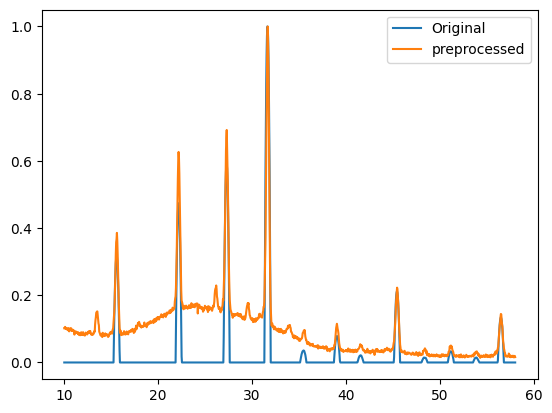

In [ ]:
rnd = 0#np.random.randint(0,100)
demo_t = post_exp[exp_min:exp_max,(rnd)]
demo_x = exp_arr_new[exp_min:exp_max,0]
plt.plot(demo_x,post_exp[:, 0],label='Original')
plt.plot(demo_x,nexp[exp_min:exp_max, 0], label='preprocessed')
plt.legend(loc='upper right')
plt.show()

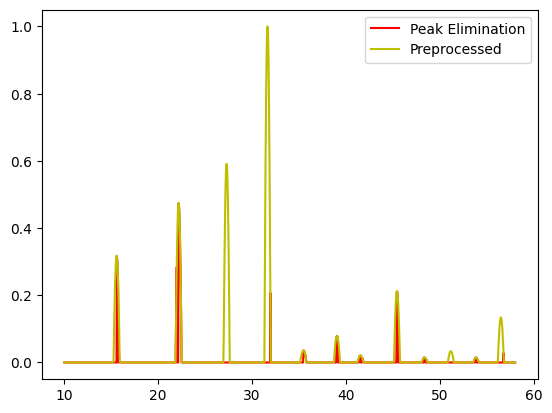

In [ ]:
#add in the first filter (peak elimination)
dum1= np.repeat(np.random.choice([0,0,1],300),len(demo_x)//300)
demo_1st = np.multiply(demo_t,dum1)
#plot
plt.plot(demo_x,demo_1st,label='Peak Elimination', color= 'r')
plt.plot(demo_x, demo_t, label='Preprocessed', color='y')
plt.legend(loc='upper right')
plt.show()

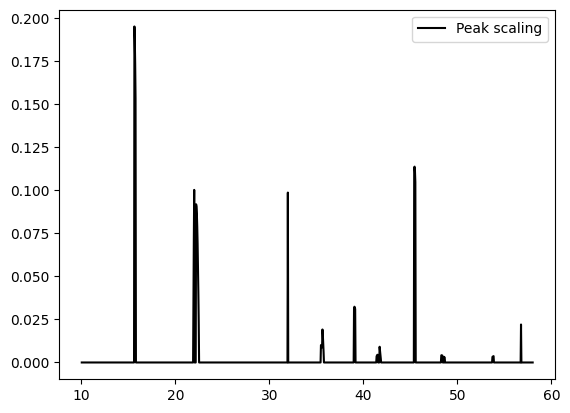

In [ ]:
dum2= np.repeat(np.random.rand(150,),len(demo_x)//150)
demo_2nd = np.multiply( demo_1st,dum2)
#plot
plt.plot(demo_x,demo_2nd,label='Peak scaling', color= 'k')
plt.legend(loc='upper right')
plt.show()

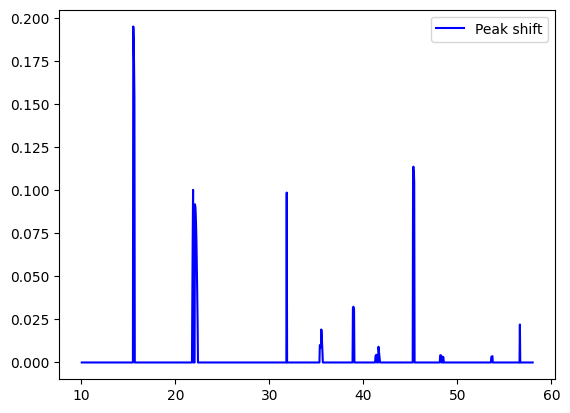

In [ ]:
cut = np.random.randint(-20*1,20)
#XRD spectrum shift to left
if cut>=0:
    demo_3rd = np.append(demo_2nd[cut:,],np.zeros([cut,]))
#XRD spectrum shift to right
else:
    demo_3rd = np.append(demo_2nd[0:len(demo_x)+cut,],np.zeros([cut*-1,]))
#plot
plt.plot(demo_x,demo_3rd,label='Peak shift', color= 'b')
plt.legend(loc='upper right')
plt.show()

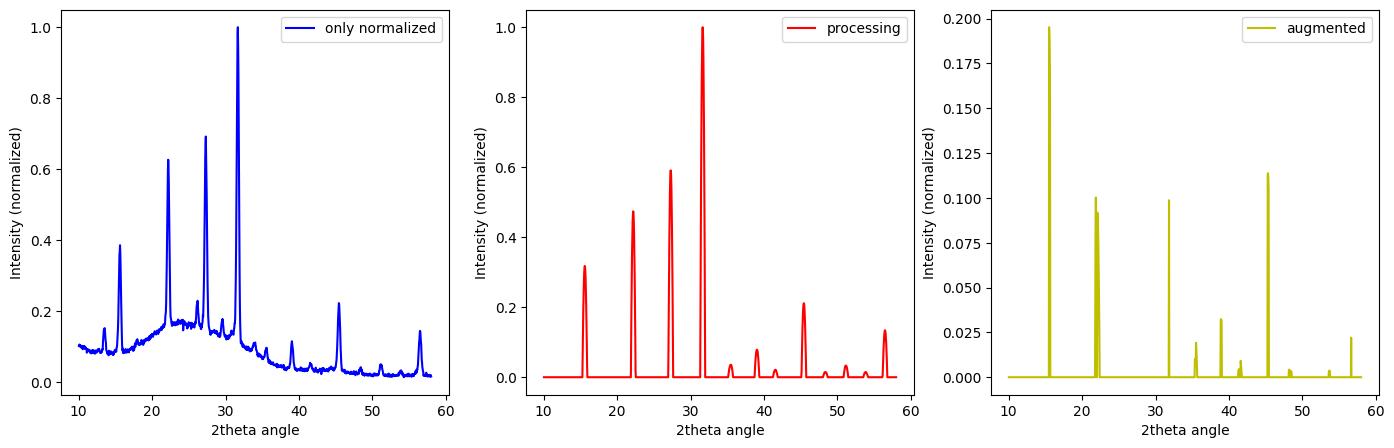

<ipython-input-73-21c9c3ba4b88>:17: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


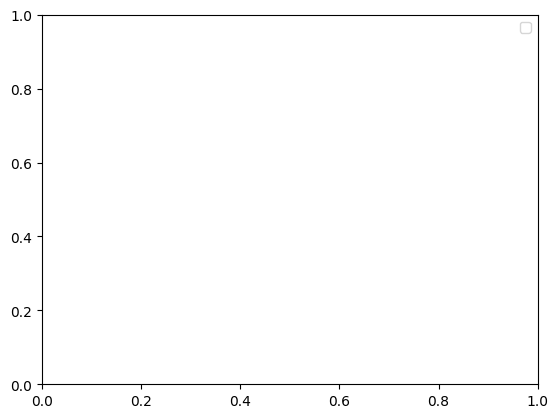

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(17, 5))
axs[0].plot(demo_x, nexp[exp_min:exp_max, 0], label='only normalized', color='b')
axs[1].plot(demo_x, post_exp[:, 0], label='processing', color='r')
axs[2].plot(demo_x, demo_3rd, label='augmented', color='y')
axs[0].legend()
axs[1].legend()
axs[2].legend()
axs[0].set_ylabel('Intensity (normalized)')
axs[1].set_ylabel('Intensity (normalized)')
axs[2].set_ylabel('Intensity (normalized)')
axs[0].set_xlabel('2theta angle')
axs[1].set_xlabel('2theta angle')
axs[2].set_xlabel('2theta angle')
plt.show()
# plt.ylabel('Intensity (normalized)')
# plt.xlabel('2theta angle')
plt.legend()
fig.tight_layout()

In [ ]:
df

,Space group label,Counts in training dataset
0,Fm-3m,773
1,I41mcm,426
2,P21a,372
3,P3m1,452
4,P61mmc,217
5,Pc,115
6,Pm-3m,1245


# Data preparation

In [174]:
def data_prep():
    enc = OneHotEncoder()

    train_dim = x_train.reshape(x_train.shape[0],1200,1)
    train_y = y_train
    train_y_hot = enc.fit_transform(train_y.reshape(-1,1)).toarray()  # Convert to dense array

    # Define test data
    test_x = X_test.reshape(X_test.shape[0],1200,1)
    test_y = enc.fit_transform(y_test.reshape(-1,1)).toarray()

    if isinstance(train_y_hot, tf.sparse.SparseTensor):
        train_y_hot = tf.sparse.to_dense(train_y_hot)

    return train_dim, train_y_hot, test_x, test_y

train_dim, train_y_hot, test_x, test_y = data_prep()


# Defining different models

below you can write a function where we define specific models which can be loaded, evaluated and for which we can plot a confusion matrix

## CNN model

In [173]:

# Define network structure
def a_cnn_model(train_dim, train_y_hot, test_x, test_y):
    # Clear weights and networks state
    K.backend.clear_session()

    # Network Parameters
    BATCH_SIZE=128
    n_input = 1200 # MNIST data input (img shape: 28*28)
    n_classes = 7 # MNIST total classes (0-9 digits)
    filter_size = 2
    kernel_size = 10

    model = Sequential()

    model.add(K.layers.Conv1D(32, 8,strides=8, padding='same',input_shape=(1200,1), activation='relu'))
    model.add(K.layers.Conv1D(32, 5,strides=5, padding='same', activation='relu'))
    model.add(K.layers.Conv1D(32, 3,strides=3, padding='same', activation='relu'))
    model.add(GlobalAveragePooling1D())
    model.add(K.layers.Dense(n_classes, activation='softmax'))

    #Define optimizer
    optimizer = K.optimizers.Adam()

    # Compile model
    model.compile(loss='binary_crossentropy',
                    optimizer=optimizer,
                    metrics=['categorical_accuracy'])
    hist = model.fit(train_dim, train_y_hot, batch_size=BATCH_SIZE, epochs=100,
                        verbose=1, validation_data=(test_x, test_y))
    return model, hist

## CNN model but with L1 regularization in each Conv1D layer

In [78]:

# Define network structure
def a_cnn_model_reg(train_dim, train_y_hot, test_x, test_y):
    # Clear weights and networks state
    K.backend.clear_session()

    # Network Parameters
    BATCH_SIZE=128
    n_input = 1200 # MNIST data input (img shape: 28*28)
    n_classes = 7 # MNIST total classes (0-9 digits)
    filter_size = 2
    kernel_size = 10

    model = Sequential()

    model.add(K.layers.Conv1D(32, 8,strides=8, padding='same',input_shape=(1200,1),
                              activation='relu',kernal_regularizer=K.regularizers.l1(0.01)))
    model.add(K.layers.Conv1D(32, 5,strides=5, padding='same',
                              activation='relu',kernal_regularizer=K.regularizers.l1(0.01)))
    model.add(K.layers.Conv1D(32, 3,strides=3, padding='same',
                              activation='relu',kernal_regularizer=K.regularizers.l1(0.01)))
    model.add(GlobalAveragePooling1D())
    model.add(K.layers.Dense(n_classes, activation='softmax'))

    #Define optimizer
    optimizer = K.optimizers.Adam()

    # Compile model
    model.compile(loss='binary_crossentropy',
                    optimizer=optimizer,
                    metrics=['categorical_accuracy'])
    hist = model.fit(train_dim, train_y_hot, batch_size=BATCH_SIZE, epochs=100,
                        verbose=1, validation_data=(test_x, test_y))
    return model, hist

## paper CNN but with more features for lower levels

In [25]:
# Define network structure
def a_cnn_model_features(train_dim, train_y_hot, test_x, test_y):
    # Clear weights and networks state
    K.backend.clear_session()

    # Network Parameters
    BATCH_SIZE=128
    n_input = 1200 # MNIST data input (img shape: 28*28)
    n_classes = 7 # MNIST total classes (0-9 digits)
    filter_size = 2
    kernel_size = 10

    model = Sequential()

    model.add(K.layers.Conv1D(32, 8,strides=8, padding='same',input_shape=(1200,1), activation='relu'))
    model.add(K.layers.Conv1D(64, 5,strides=5, padding='same', activation='relu'))
    model.add(K.layers.Conv1D(128, 3,strides=3, padding='same', activation='relu'))
    model.add(GlobalAveragePooling1D())
    model.add(K.layers.Dense(n_classes, activation='softmax'))

    #Define optimizer
    optimizer = K.optimizers.Adam()

    # Compile model
    model.compile(loss='binary_crossentropy',
                    optimizer=optimizer,
                    metrics=['categorical_accuracy'])
    hist = model.fit(train_dim, train_y_hot, batch_size=BATCH_SIZE, epochs=100,
                        verbose=1, validation_data=(test_x, test_y))
    return model, hist

## CNN with more layers (2 more layers)
* added one Conv1D with 5 strides and one with 3 strides

In [26]:
# Define network structure
def cnn_model_layers(train_dim, train_y_hot, test_x, test_y):
    # Clear weights and networks state
    K.backend.clear_session()

    # Network Parameters
    BATCH_SIZE=128
    n_input = 1200 # MNIST data input (img shape: 28*28)
    n_classes = 7 # MNIST total classes (0-9 digits)
    filter_size = 2
    kernel_size = 10

    model = Sequential()

    model.add(K.layers.Conv1D(32, 8,strides=8, padding='same',input_shape=(1200,1), activation='relu'))
    model.add(K.layers.Conv1D(32, 5,strides=5, padding='same', activation='relu'))
    model.add(K.layers.Conv1D(32, 5,strides=5, padding='same', activation='relu'))
    model.add(K.layers.Conv1D(32, 3,strides=3, padding='same', activation='relu'))
    model.add(K.layers.Conv1D(32, 3,strides=3, padding='same', activation='relu'))
    model.add(GlobalAveragePooling1D())
    model.add(K.layers.Dense(n_classes, activation='softmax'))

    #Define optimizer
    optimizer = K.optimizers.Adam()

    # Compile model
    model.compile(loss='binary_crossentropy',
                    optimizer=optimizer,
                    metrics=['categorical_accuracy'])
    hist = model.fit(train_dim, train_y_hot, batch_size=BATCH_SIZE, epochs=100,
                        verbose=1, validation_data=(test_x, test_y))
    return model, hist

## CNN model with batchnorm

I experimented with a CNN model which has batchnorm but I found that only 1 batchnorm layer works the best

In [27]:

# Define network structure
def batchnorm_model(train_dim, train_y_hot, test_x, test_y):
    # Clear weights and networks state
    K.backend.clear_session()

    # Network Parameters
    BATCH_SIZE=128
    n_input = 1200 # MNIST data input (img shape: 28*28)
    n_classes = 7 # MNIST total classes (0-9 digits)
    filter_size = 2
    kernel_size = 10

    model = Sequential()

    model.add(K.layers.Conv1D(32, 8,strides=8, padding='same',input_shape=(1200,1), activation='relu'))
    model.add(K.layers.BatchNormalization())
    model.add(K.layers.Conv1D(32, 5,strides=5, padding='same', activation='relu'))
    # model.add(K.layers.BatchNormalization())
    model.add(K.layers.Conv1D(32, 3,strides=3, padding='same', activation='relu'))
    # model.add(K.layers.BatchNormalization())
    model.add(GlobalAveragePooling1D())
    model.add(K.layers.Dense(n_classes, activation='softmax'))

    #Define optimizer
    optimizer = K.optimizers.Adam()

    # Compile model
    model.compile(loss='binary_crossentropy',
                    optimizer=optimizer,
                    metrics=['categorical_accuracy'])
    hist = model.fit(train_dim, train_y_hot, batch_size=BATCH_SIZE, epochs=100,
                        verbose=1, validation_data=(test_x, test_y))
    return model, hist

## CNN with batchnorm with a different optimizer

In [28]:

# Define network structure
def batchnorm_model_sgd(train_dim, train_y_hot, test_x, test_y):
    # Clear weights and networks state
    K.backend.clear_session()

    # Network Parameters
    BATCH_SIZE=128
    n_input = 1200 # MNIST data input (img shape: 28*28)
    n_classes = 7 # MNIST total classes (0-9 digits)
    filter_size = 2
    kernel_size = 10

    model = Sequential()

    model.add(K.layers.Conv1D(32, 8,strides=8, padding='same',input_shape=(1200,1), activation='relu'))
    model.add(K.layers.BatchNormalization())
    model.add(K.layers.Conv1D(32, 5,strides=5, padding='same', activation='relu'))
    # model.add(K.layers.BatchNormalization())
    model.add(K.layers.Conv1D(32, 3,strides=3, padding='same', activation='relu'))
    # model.add(K.layers.BatchNormalization())
    model.add(GlobalAveragePooling1D())
    model.add(K.layers.Dense(n_classes, activation='softmax'))

    #Define optimizer
    optimizer = K.optimizers.SGD(learning_rate = 0.1, momentum=0.01)

    # Compile model
    model.compile(loss='binary_crossentropy',
                    optimizer=optimizer,
                    metrics=['categorical_accuracy'])
    hist = model.fit(train_dim, train_y_hot, batch_size=BATCH_SIZE, epochs=100,
                        verbose=1, validation_data=(test_x, test_y))
    return model, hist

# Decision tree

In [29]:
import xgboost as xgb
def decision_tree(train_dim, train_y_hot):

    # Convert one-hot encoding to class indices
    #have to convert one hot back to indices
    y_train = np.argmax(train_y_hot, axis=1)
    x_training = train_dim.reshape(train_dim.shape[0], -1)
    # Create DMatrix for XGBoost
    dtrain = xgb.DMatrix(x_training, label=y_train)
    # dtest = xgb.DMatrix(X_test, label=y_test)

    # XGBoost parameters for multiclass classification
    params = {
        "objective": "multi:softmax",  # Multi-class classification
        "num_class": 7,  # Number of classes
        "eval_metric": "mlogloss",  # Multi-class log loss
    }

    # Train the model
    num_round = 100  # Number of boosting rounds
    model = xgb.train(params, dtrain, num_round)

    return model

# Confusion matrix

In [30]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

def conf_matrix(model):
    prediction = model.predict(test_x)
    # For a classification task, convert predictions to class labels (if needed)
    prediction_ord=[np.argmax(element) for element in prediction]


    # If your true labels are one-hot encoded, you may need to convert them as well
    true_labels = [np.argmax(element) for element in test_y]

    cm = confusion_matrix(true_labels, prediction_ord, normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(label_theo))
    disp.plot()
    plt.show()
    return None

# ROC Curves

Using ROC to evaluate multiple classes requires more consideration.
We have used the one-vs-rest (OVR) stategy, which is also refered to as the one-vs-all strategy. In this method, the ROC for each class is determined where a given class is regarded as the positive class and the remaining classes are regarded as the negative class as a bulk.

We consider both the micro-averaging and macro-averaging.

In micro-averaged OvR, the average metrics are computed as:
$$ TPR = \frac{\sum_CTP_C}{\sum_C(TP_C + FN_C)};$$
$$ FPR = \frac{\sum_CFP_C}{\sum_C(FP_C + TN_C)}.$$
Mainly, the contributions from all the classes are considered. Note, this is usefull for highly imbalanced classes as not all classses are treated equally prior to the calculation.

For macro-averaging, the metrics are computed independently for each class and then taking the average over them.
$$ TPR = \frac{1}{C}\sum_C\frac{TP_C}{TP_C + FN_C};$$
$$ FPR = \frac{1}{C}\sum_C\frac{FP_C}{FP_C + TN_C}.$$

In [31]:
from sklearn.metrics import roc_curve, auc

def plot_roc_OVR(model, test_x, test_y, X_test=None):
  """
  Determines and plots the ROC for the class vs rest classification.
  """
  prediction = model.predict(test_x)

  n_classes = len(np.unique(label_theo))

  # Compute ROC curve and AUC for each class
  fpr, tpr, roc_auc = dict(), dict(), dict()

  # ROC for each class
  for i in range(n_classes):  # 7 classes
      fpr[i], tpr[i], _ = roc_curve(test_y[:, i], prediction[:, i])
      roc_auc[i]= auc(fpr[i], tpr[i])


  # Micro-average ROC curve and AUC
  fpr["micro"], tpr["micro"], _ = roc_curve(test_y.ravel(), prediction.ravel())
  roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

  # Compute macro-average ROC curve and AUC
  fpr_grid = np.linspace(0.0 , 1.0, 1000)

  # linear interpolate all ROC curves at the points
  mean_tpr = np.zeros_like(fpr_grid)
  for i in range(n_classes):
      mean_tpr += np.interp(fpr_grid, fpr[i], tpr[i])

  # average it and then compute macros AUC
  mean_tpr /= n_classes

  fpr["macro"] = fpr_grid
  tpr["macro"] = mean_tpr
  roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

  #### Plotting all together ####

  plt.figure(figsize=(6, 6))

  # Plot ROC for each class
  colors = ['blue', 'red', 'green', 'purple', 'orange', 'brown', 'pink']
  for i, color in enumerate(colors):
      plt.plot(fpr[i], tpr[i], color=color, lw=2,
               label=f'{space_group_enc[i]} (AUC = {roc_auc[i]:.2f})')

  # Plot micro and macro average ROC curves
  plt.plot(fpr["micro"], tpr["micro"], linestyle='--', color='black',
           label=f'Micro Avg (AUC = {roc_auc["micro"]:.2f})', lw=2)
  plt.plot(fpr["macro"], tpr["macro"], linestyle='--', color='gray',
           label=f'Macro Avg (AUC = {roc_auc["macro"]:.2f})', lw=2)

  # Plot diagonal line
  plt.plot([0, 1], [0, 1], color='gray', linestyle='--',
           label = "Chance level (AUC = 0.5)")

  # Labels and title
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Multi-Class ROC Curve')
  plt.legend(loc='lower right')
  plt.show()


In [13]:
def plot_roc_OVR_Tree(model, X_test, test_y):
  """
  Determines and plots the ROC for the class vs rest classification.
  """

  dtest = xgb.DMatrix(X_test, label=test_y)

  y_pred = model.predict(dtest)

  enc = OneHotEncoder()
  pred_y_hot = enc.fit_transform(y_pred.reshape(-1,1)).toarray()  # Convert to dense array

  test_y_hot = enc.fit_transform(test_y.reshape(-1,1)).toarray()  # Convert to dense array

  print("test_y.shape", test_y.shape)
  print("pred_y.shape",y_pred.shape)
  print("test_y_hot.shape", test_y_hot.shape)
  print("pred_y_hot.shape",pred_y_hot.shape)

  n_classes = 7

  # Compute ROC curve and AUC for each class
  fpr, tpr, roc_auc = dict(), dict(), dict()

  # ROC for each class
  for i in range(n_classes):  # 7 classes
      fpr[i], tpr[i], _ = roc_curve(test_y_hot[:, i], pred_y_hot[:, i])
      roc_auc[i]= auc(fpr[i], tpr[i])


  # Micro-average ROC curve and AUC
  fpr["micro"], tpr["micro"], _ = roc_curve(test_y_hot.ravel(), pred_y_hot.ravel())
  roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

  # Compute macro-average ROC curve and AUC
  fpr_grid = np.linspace(0.0 , 1.0, 1000)

  # linear interpolate all ROC curves at the points
  mean_tpr = np.zeros_like(fpr_grid)
  for i in range(n_classes):
      mean_tpr += np.interp(fpr_grid, fpr[i], tpr[i])

  # average it and then compute macros AUC
  mean_tpr /= n_classes

  fpr["macro"] = fpr_grid
  tpr["macro"] = mean_tpr
  roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

  #### Plotting all together ####

  plt.figure(figsize=(6, 6))

  # Plot ROC for each class
  colors = ['blue', 'red', 'green', 'purple', 'orange', 'brown', 'pink']
  for i, color in enumerate(colors):
      plt.plot(fpr[i], tpr[i], color=color, lw=2,
               label=f'{space_group_enc[i]} (AUC = {roc_auc[i]:.2f})')

  # Plot micro and macro average ROC curves
  plt.plot(fpr["micro"], tpr["micro"], linestyle='--', color='black',
           label=f'Micro Avg (AUC = {roc_auc["micro"]:.2f})', lw=2)
  plt.plot(fpr["macro"], tpr["macro"], linestyle='--', color='gray',
           label=f'Macro Avg (AUC = {roc_auc["macro"]:.2f})', lw=2)

  # Plot diagonal line
  plt.plot([0, 1], [0, 1], color='gray', linestyle='--',
           label = "Chance level (AUC = 0.5)")

  # Labels and title
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Multi-Class ROC Curve')
  plt.legend(loc='lower right')
  plt.show()

## Transformers

This code is shamelessly generated by my favorite transformer dr. GPT

In [ ]:
from tensorflow.keras import layers
from tensorflow import keras

# Transformer Encoder Block
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, dropout_rate=0.1):
        super().__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential([
            layers.Dense(ff_dim, activation="relu"),
            layers.Dense(embed_dim),
        ])
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(dropout_rate)
        self.dropout2 = layers.Dropout(dropout_rate)

    def call(self, inputs, training=False):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)

        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

# Positional Encoding (since Transformers lack inherent position awareness)
class PositionalEncoding(layers.Layer):
    def __init__(self, sequence_length, embed_dim):
        super().__init__()
        self.position_embeddings = layers.Embedding(input_dim=sequence_length, output_dim=embed_dim)

    def call(self, inputs):
        positions = tf.range(start=0, limit=tf.shape(inputs)[1], delta=1)
        return inputs + self.position_embeddings(positions)

# Define the full Transformer model
def build_transformer_model(seq_length, embed_dim, num_heads, ff_dim, num_classes):
    inputs = layers.Input(shape=(seq_length, 1))  # XRD spectra as sequences
    x = layers.Conv1D(embed_dim, kernel_size=3, padding="same", activation="relu")(inputs)  # Learn embeddings
    x = PositionalEncoding(seq_length, embed_dim)(x)

    # Stack Transformer Encoder blocks
    for _ in range(2):  # Number of Transformer layers
        x = TransformerEncoder(embed_dim, num_heads, ff_dim)(x)

    x = layers.GlobalAveragePooling1D()(x)  # Aggregate features
    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)  # Classification output

    model = keras.Model(inputs, outputs)
    return model

Model: "functional_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_13 (InputLayer)          │ (None, 1200, 1)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_7 (Conv1D)                    │ (None, 1200, 64)            │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ positional_encoding_4                │ (None, 1200, 64)            │          76,800 │
│ (PositionalEncoding)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_encoder_8                │ (None, 1200, 64)            │          83,200 │
│ (TransformerEncoder)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_encoder_9                │ (None, 1200, 64)            │          83,200 │
│ (TransformerEncoder)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_5           │ (None, 64)                  │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_34 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ (None, 7)                   │             455 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 243,911 (952.78 KB)

 Trainable params: 243,911 (952.78 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
def build_transformer(train_dim, train_y_hot, test_x, test_y):
    # Hyperparameters
    seq_length = train_dim.shape[1]
    embed_dim = 64  # Feature size
    num_heads = 4  # Number of attention heads
    ff_dim = 128  # Feedforward layer size
    # num_classes = len(np.unique(y_train))
    num_classes = 7

    # Build and compile the model
    transformer_model = build_transformer_model(seq_length, embed_dim, num_heads, ff_dim, num_classes)
    transformer_model.compile(
        loss="categorical_crossentropy",
        optimizer=keras.optimizers.Adam(learning_rate=1e-4),
        metrics=["accuracy"]
    )

    transformer_model.summary()
    hist = transformer_model.fit(train_dim, train_y_hot, batch_size=128, epochs=100,
                        verbose=1, validation_data =(test_x, test_y))

    return tranformer_model, hist

# Training different models

## CNN

In [175]:
cnn_model, cnn_hist = a_cnn_model(train_dim, train_y_hot, test_x, test_y)

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - categorical_accuracy: 0.1637 - loss: 0.6659 - val_categorical_accuracy: 0.0238 - val_loss: 0.4628
Epoch 2/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - categorical_accuracy: 0.1479 - loss: 0.4243 - val_categorical_accuracy: 0.1349 - val_loss: 0.4111
Epoch 3/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - categorical_accuracy: 0.2129 - loss: 0.4089 - val_categorical_accuracy: 0.1429 - val_loss: 0.4126
Epoch 4/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - categorical_accuracy: 0.2751 - loss: 0.4058 - val_categorical_accuracy: 0.2619 - val_loss: 0.4039
Epoch 5/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - categorical_accuracy: 0.3949 - loss: 0.3931 - val_categorical_accuracy: 0.1667 - val_loss: 0.4033
Epoch 6/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - categorical_accuracy: 0.4348 - loss: 0.3589 - val_categorical_accuracy: 0.1905 - val_loss: 0.4164
Epoch 7/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - categorical_accuracy: 0.4809 - loss: 0.3237 - 

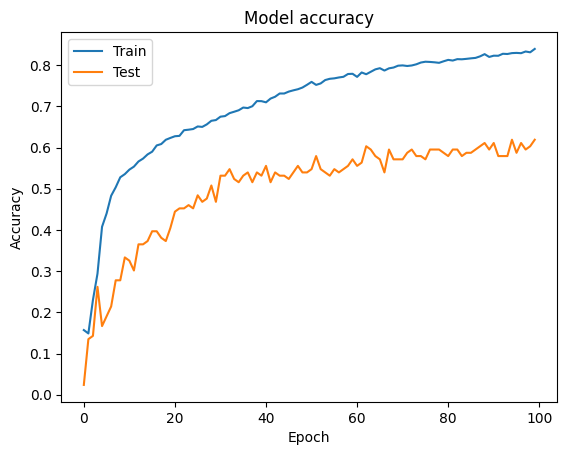

In [176]:
plt.plot(cnn_hist.history['categorical_accuracy'])
plt.plot(cnn_hist.history['val_categorical_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


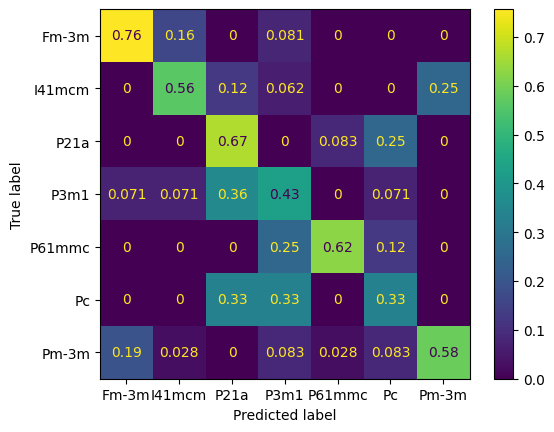

In [177]:
conf_matrix(cnn_model)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


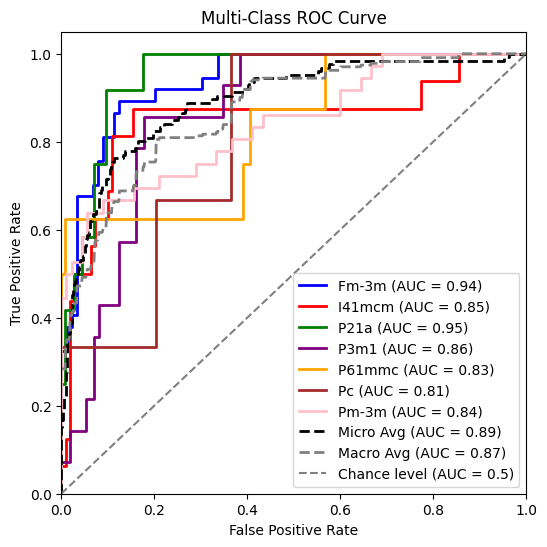

In [178]:
plot_roc_OVR(cnn_model, test_x, test_y)

## CNN with regulariztion


In [80]:
cnn_reg_model, cnn_reg_hist = a_cnn_model(train_dim, train_y_hot, test_x, test_y)

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - categorical_accuracy: 0.1879 - loss: 0.6870 - val_categorical_accuracy: 0.4091 - val_loss: 0.6523
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - categorical_accuracy: 0.2530 - loss: 0.6244 - val_categorical_accuracy: 0.4659 - val_loss: 0.4883
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - categorical_accuracy: 0.2384 - loss: 0.4444 - val_categorical_accuracy: 0.0455 - val_loss: 0.4462
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - categorical_accuracy: 0.3571 - loss: 0.3836 - val_categorical_accuracy: 0.0455 - val_loss: 0.4351
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - categorical_accuracy: 0.3604 - loss: 0.3738 - val_categorical_accuracy: 0.0455 - val_loss: 0.4436
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - categorical_accuracy: 0.3387 - loss: 0.3743 - val_categorical_accuracy: 0.0455 - val_loss: 0.4317
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - categorical_accuracy: 0.3342 - loss: 0.3755 - 

## CNN with batchnorm

In [182]:
cnn_batchnorm_model, batchnorm_hist = batchnorm_model(train_dim, train_y_hot, test_x, test_y)

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - categorical_accuracy: 0.1501 - loss: 0.6200 - val_categorical_accuracy: 0.1587 - val_loss: 0.5423
Epoch 2/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - categorical_accuracy: 0.3540 - loss: 0.3832 - val_categorical_accuracy: 0.2698 - val_loss: 0.5427
Epoch 3/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - categorical_accuracy: 0.4984 - loss: 0.3269 - val_categorical_accuracy: 0.2540 - val_loss: 0.5133
Epoch 4/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - categorical_accuracy: 0.5290 - loss: 0.3011 - val_categorical_accuracy: 0.3254 - val_loss: 0.4868
Epoch 5/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - categorical_accuracy: 0.5617 - loss: 0.2851 - val_categorical_accuracy: 0.3016 - val_loss: 0.4677
Epoch 6/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - categorical_accuracy: 0.5928 - loss: 0.2709 - val_categorical_accuracy: 0.2698 - val_loss: 0.4520
Epoch 7/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - categorical_accuracy: 0.6260 - loss: 0.2599 - 

In [183]:
batchnorm_hist.history.keys()

dict_keys(['categorical_accuracy', 'loss', 'val_categorical_accuracy', 'val_loss'])

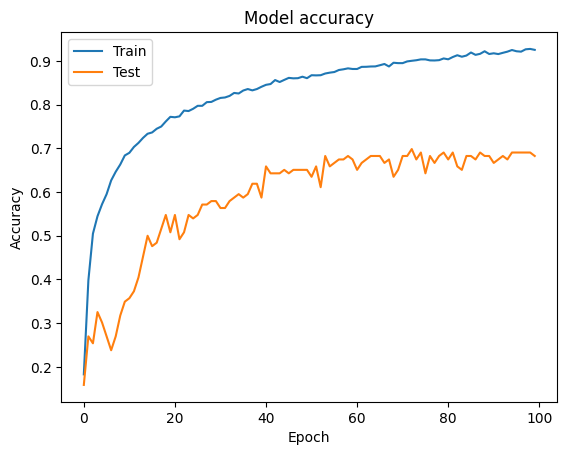

In [185]:
plt.plot(batchnorm_hist.history['categorical_accuracy'])
plt.plot(batchnorm_hist.history['val_categorical_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


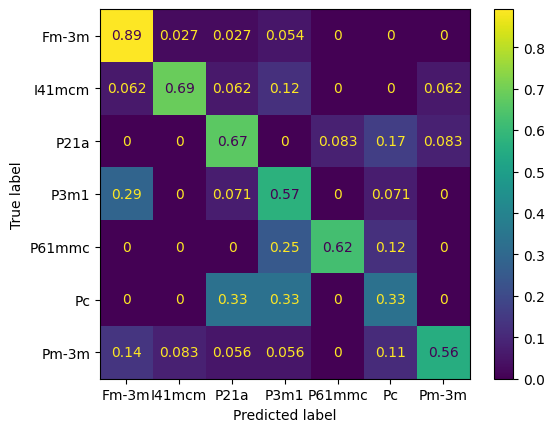

In [186]:
conf_matrix(cnn_batchnorm_model)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


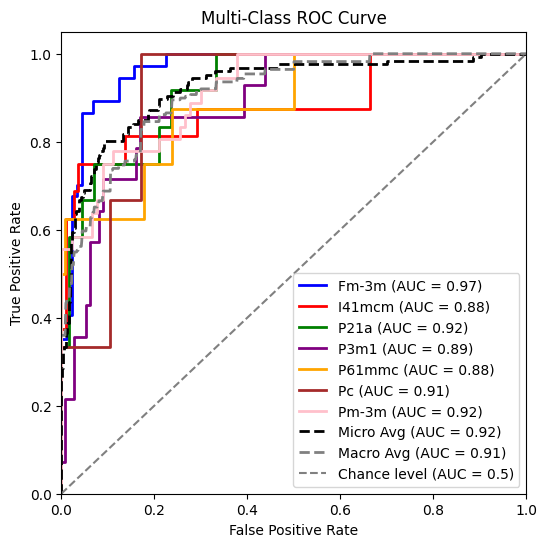

In [187]:
plot_roc_OVR(cnn_batchnorm_model, test_x, test_y)

## CNN batchnorm with SGD

In [ ]:
sgd_cnn, sgd_hist = batchnorm_model_sgd(train_dim, train_y_hot, test_x, test_y)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - categorical_accuracy: 0.1589 - loss: 0.6834 - val_categorical_accuracy: 0.6160 - val_loss: 0.6069
Epoch 2/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - categorical_accuracy: 0.3398 - loss: 0.5840 - val_categorical_accuracy: 0.6160 - val_loss: 0.4922
Epoch 3/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - categorical_accuracy: 0.3554 - loss: 0.4607 - val_categorical_accuracy: 0.6160 - val_loss: 0.3676
Epoch 4/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - categorical_accuracy: 0.3495 - loss: 0.3815 - val_categorical_accuracy: 0.6160 - val_loss: 0.3332
Epoch 5/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - categorical_accuracy: 0.3439 - loss: 0.3721 - val_categorical_accuracy: 0.6160 - val_loss: 0.3309
Epoch 6/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - categorical_accuracy: 0.3449 - loss: 0.3679 - val_categorical_accuracy: 0.6160 - val_loss: 0.3311
Epoch 7/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - categorical_accuracy: 0.3481 - loss: 0

## CNN with more conv1D layers

In [188]:
layers_cnn, layers_hist = cnn_model_layers(train_dim, train_y_hot, test_x, test_y)

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - categorical_accuracy: 0.1751 - loss: 0.6477 - val_categorical_accuracy: 0.0635 - val_loss: 0.4141
Epoch 2/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - categorical_accuracy: 0.1564 - loss: 0.4134 - val_categorical_accuracy: 0.2222 - val_loss: 0.4090
Epoch 3/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - categorical_accuracy: 0.3622 - loss: 0.3945 - val_categorical_accuracy: 0.2063 - val_loss: 0.4193
Epoch 4/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - categorical_accuracy: 0.5681 - loss: 0.2891 - val_categorical_accuracy: 0.3492 - val_loss: 0.3850
Epoch 5/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - categorical_accuracy: 0.7492 - loss: 0.1868 - val_categorical_accuracy: 0.6508 - val_loss: 0.3382
Epoch 6/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - categorical_accuracy: 0.8434 - loss: 0.1340 - val_categorical_accuracy: 0.7063 - val_loss: 0.3772
Epoch 7/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - categorical_accuracy: 0.8749 - loss: 0.1093 - 

In [25]:
layers_cnn.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 150, 32)             │             288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 30, 32)              │           5,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 6, 32)               │           5,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_3 (Conv1D)                    │ (None, 2, 32)               │           3,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_4 (Conv1D)                    │ (None, 1, 32)               │           3,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ (None, 32)                  │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 7)                   │             231 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 51,095 (199.59 KB)

 Trainable params: 17,031 (66.53 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 34,064 (133.07 KB)

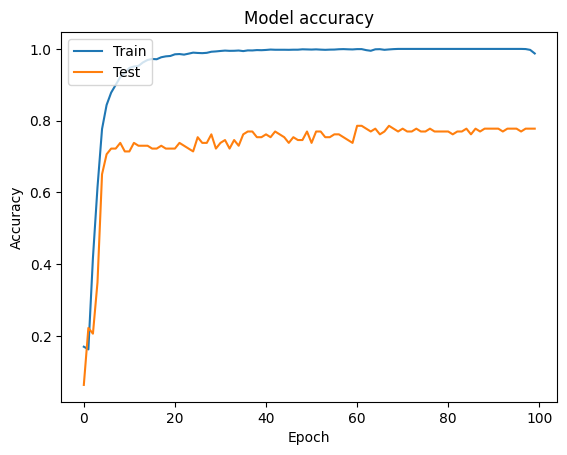

In [189]:
plt.plot(layers_hist.history['categorical_accuracy'])
plt.plot(layers_hist.history['val_categorical_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


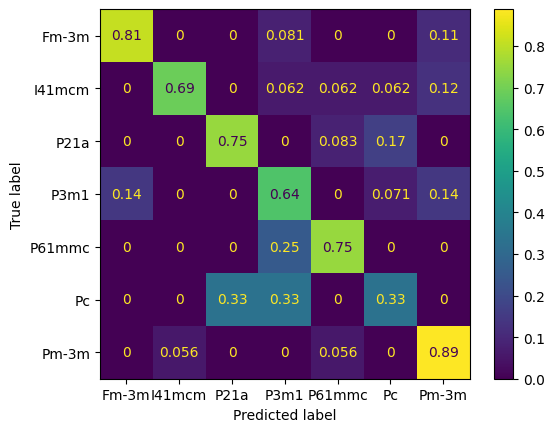

In [190]:
conf_matrix(layers_cnn)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


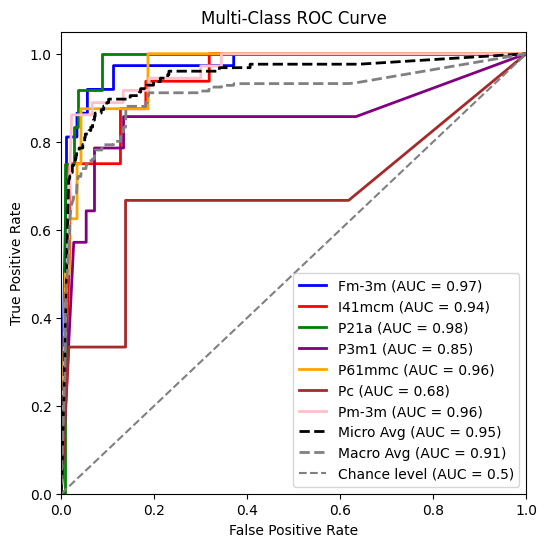

In [191]:
plot_roc_OVR(layers_cnn, test_x, test_y)

## CNN with different num of features

In [28]:
feat_cnn, feat_hist = a_cnn_model_features(train_dim, train_y_hot, test_x, test_y)

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - categorical_accuracy: 0.1355 - loss: 0.6667 - val_categorical_accuracy: 0.1287 - val_loss: 0.4261
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - categorical_accuracy: 0.2694 - loss: 0.3972 - val_categorical_accuracy: 0.3988 - val_loss: 0.3641
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - categorical_accuracy: 0.3676 - loss: 0.3705 - val_categorical_accuracy: 0.3988 - val_loss: 0.3590
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - categorical_accuracy: 0.3677 - loss: 0.3670 - val_categorical_accuracy: 0.3988 - val_loss: 0.3562
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - categorical_accuracy: 0.3557 - loss: 0.3643 - val_categorical_accuracy: 0.3988 - val_loss: 0.3486
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - categorical_accuracy: 0.3732 - loss: 0.3522 - val_categorical_accuracy: 0.4150 - val_loss: 0.3346
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - categorical_accuracy: 0.4021 - loss: 0.3359 - val_ca

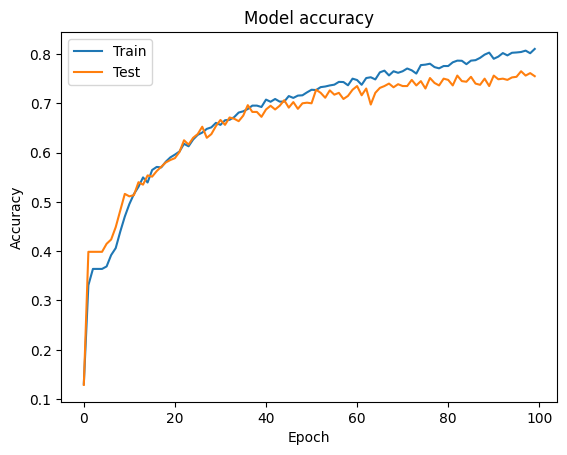

In [29]:
plt.plot(feat_hist.history['categorical_accuracy'])
plt.plot(feat_hist.history['val_categorical_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## Decision tree

In [179]:
model_tree = decision_tree(train_dim, train_y_hot)

## transformer

In [ ]:
transformer_model = build_transformer(train_dim, train_y_hot, test_x, test_y)

# Evaluating the models

## CNN

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - categorical_accuracy: 0.6796 - loss: 0.2166
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


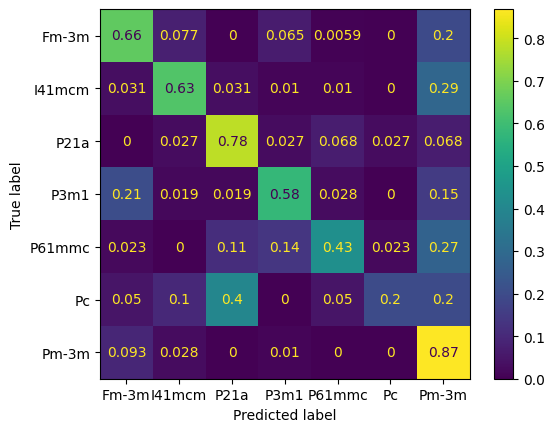

In [ ]:
cnn_model.evaluate(test_x, test_y, return_dict = True)
conf_matrix(cnn_model)

## CNN with batchnorm

Only 1 batchnorm layer. Works the best for me

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


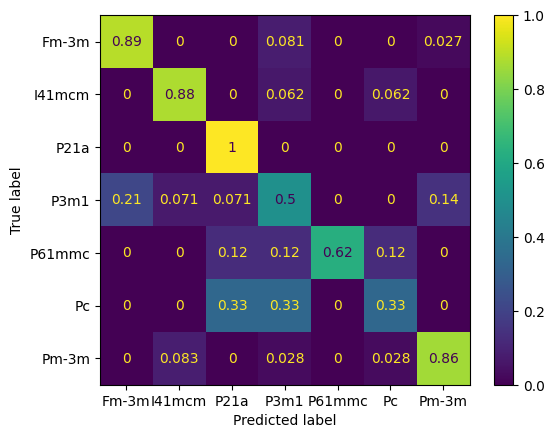

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - categorical_accuracy: 0.7697 - loss: 0.2234 


{'categorical_accuracy': 0.817460298538208, 'loss': 0.19014586508274078}

In [181]:
conf_matrix(cnn_batchnorm_model)
cnn_batchnorm_model.evaluate(test_x, test_y, return_dict = True)

## Decision tree

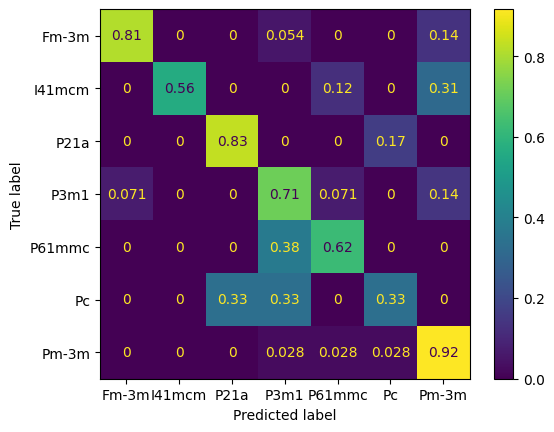

Accuracy: 0.7777777777777778


In [180]:
from sklearn.metrics import accuracy_score

dtest = xgb.DMatrix(X_test, label=y_test)

y_pred = model_tree.predict(dtest)

cm = confusion_matrix(y_test, y_pred, normalize='true')
# cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(label_theo))
disp.plot()
plt.show()

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

## CNN with batchnorm and SGD optimizer

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


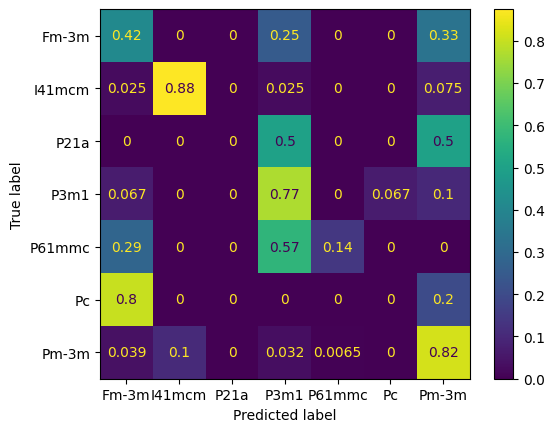

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - categorical_accuracy: 0.7535 - loss: 0.1892 


{'categorical_accuracy': 0.7599999904632568, 'loss': 0.1907568722963333}

In [ ]:
conf_matrix(sgd_cnn)
sgd_cnn.evaluate(test_x, test_y, return_dict = True)

## Transformer

In [ ]:
conf_matrix(transformer_model)
transformer_model.evaluate(test_x, test_y, return_dict = True)